### Импортируем библиотеки

In [24]:
import tensorflow.compat.v1 as tf
import numpy as np
import math
import scipy.io
import matplotlib.pyplot as plt

In [25]:
tf.disable_v2_behavior()

### Прописываем функции для нейронной сети

In [26]:
def xavier(size):
    in_dim = size[0]
    out_dim = size[1]        
    xavier_stddev = np.sqrt(2/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

In [27]:
def initialization(layers):        
    weights = []
    biases = []
    num_layers = len(layers) 
    for l in range(0,num_layers-1):
        W = xavier(size=[layers[l], layers[l+1]])
        b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)        
    return weights, biases

In [28]:
def neural_net(X, weights, biases,lb,ub):
    num_layers = len(weights) + 1        
    H = 2.0*(X - lb)/(ub - lb) - 1.0
    H =  tf.cast(H, dtype='float32')
    for l in range(0,num_layers-2):
        W = weights[l]
        print(H.shape,W.shape)
        b = biases[l]
        H = tf.tanh(tf.add(tf.matmul(H, W), b))
        H =  tf.cast(H, dtype='float32')
    W = weights[-1]
    b = biases[-1]
    Y = tf.add(tf.matmul(H, W), b)
    return Y

In [29]:
def burgers_NN(x, t, w, b, lb, ub):
    const = 0.01/np.pi
    lb1 = lb
    ub1 = ub
    u = neural_net(tf.concat([x,t], 1), w, b, lb1, ub1)   
    u_t = tf.gradients(u, t)[0]
    u_x = tf.gradients(u, x)[0]
    u_xx = tf.gradients(u_x, x)[0]
    f_u = u_t + u*u_x  - const*u_xx        
    return u, f_u

### Создаем данные для обучения

In [30]:
x = np.linspace(-1,1,1000).reshape(1000,1)
t = np.linspace(0,10,100).reshape(100,1)

In [31]:
X_size = x.shape[0]
T_size = t.shape[0]
print(X_size,T_size)

1000 100


In [32]:
X = np.tile(x, (1,T_size)) # X_size x T_size
T = np.tile(t, (1,X_size)).T # X_size x T_size

In [33]:
x_train = X.flatten()[:,None] # X_size*T_size x 1
t_train = T.flatten()[:,None] # X_size*T_size x 1
u_boundary1 = np.zeros(100).reshape(100,1)
u_boundary2 = np.zeros(100).reshape(100,1)
u_initial = -np.sin(np.pi*x_train[100:-100,:])

In [34]:
u_train = np.concatenate((u_boundary1,u_initial ,u_boundary2),axis=0)

In [35]:
u_train.shape 

(100000, 1)

In [36]:
idx = np.random.choice(X_size*T_size, 5000, replace=False)
x_train_random = x_train[idx,:]
t_train_random = t_train[idx,:]
u_train_random = u_train[idx,:]

### Инициализируем нейронную сеть

In [37]:
w,b = initialization([2,10,10,1])

In [38]:
print(w,b, len(w))

[<tf.Variable 'Variable_12:0' shape=(2, 10) dtype=float32_ref>, <tf.Variable 'Variable_14:0' shape=(10, 10) dtype=float32_ref>, <tf.Variable 'Variable_16:0' shape=(10, 1) dtype=float32_ref>] [<tf.Variable 'Variable_13:0' shape=(1, 10) dtype=float32_ref>, <tf.Variable 'Variable_15:0' shape=(1, 10) dtype=float32_ref>, <tf.Variable 'Variable_17:0' shape=(1, 1) dtype=float32_ref>] 3


In [39]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

Device mapping:



In [40]:
X = np.concatenate([x_train_random,t_train_random],1)
lb = X.min(0)
ub = X.max(0)

In [41]:
x_tf = tf.placeholder(tf.float32, shape=[None,x.shape[1]])
t_tf = tf.placeholder(tf.float32, shape=[None,t.shape[1]])
u_tf = tf.placeholder(tf.float32, shape=[None,1])

In [42]:
u_pred, f_pred = burgers_NN(x_tf,t_tf,w,b, lb, ub) 

(?, 2) (2, 10)
(?, 10) (10, 10)


### Определяем функцию потерь и оптимизаторы

In [43]:
loss_function = tf.reduce_sum(tf.square(f_pred)) + tf.reduce_sum(tf.square(u_tf - u_pred))

In [44]:
optimizer_Adam = tf.train.AdamOptimizer()
train_op_Adam = optimizer_Adam.minimize(loss_function)                    
init = tf.global_variables_initializer()
sess.run(init)

### Тренировка

In [45]:
tf_dict = {x_tf: x_train_random, t_tf: t_train_random, u_tf: u_train_random}
for i in range(5000):
    sess.run(train_op_Adam, tf_dict)
    print("Iteration: %d, Loss = %f" %(i,sess.run(loss_function,tf_dict)))

Iteration: 0, Loss = 4842.172852
Iteration: 1, Loss = 4748.739258
Iteration: 2, Loss = 4657.783691
Iteration: 3, Loss = 4569.199707
Iteration: 4, Loss = 4482.892090
Iteration: 5, Loss = 4398.748047
Iteration: 6, Loss = 4316.621582
Iteration: 7, Loss = 4236.345703
Iteration: 8, Loss = 4157.743652
Iteration: 9, Loss = 4080.650391
Iteration: 10, Loss = 4004.939697
Iteration: 11, Loss = 3930.526367
Iteration: 12, Loss = 3857.358154
Iteration: 13, Loss = 3785.416504
Iteration: 14, Loss = 3714.695801
Iteration: 15, Loss = 3645.201416
Iteration: 16, Loss = 3576.940674
Iteration: 17, Loss = 3509.918701
Iteration: 18, Loss = 3444.141846
Iteration: 19, Loss = 3379.599854
Iteration: 20, Loss = 3316.284668
Iteration: 21, Loss = 3254.178711
Iteration: 22, Loss = 3193.257080
Iteration: 23, Loss = 3133.487061
Iteration: 24, Loss = 3074.838135
Iteration: 25, Loss = 3017.269775
Iteration: 26, Loss = 2960.747559
Iteration: 27, Loss = 2905.237793
Iteration: 28, Loss = 2850.707520
Iteration: 29, Loss = 27

Iteration: 253, Loss = 1146.998779
Iteration: 254, Loss = 1145.967285
Iteration: 255, Loss = 1144.930298
Iteration: 256, Loss = 1143.889160
Iteration: 257, Loss = 1142.842896
Iteration: 258, Loss = 1141.791992
Iteration: 259, Loss = 1140.736206
Iteration: 260, Loss = 1139.676025
Iteration: 261, Loss = 1138.611206
Iteration: 262, Loss = 1137.541138
Iteration: 263, Loss = 1136.466309
Iteration: 264, Loss = 1135.387085
Iteration: 265, Loss = 1134.302734
Iteration: 266, Loss = 1133.213989
Iteration: 267, Loss = 1132.120239
Iteration: 268, Loss = 1131.022217
Iteration: 269, Loss = 1129.918945
Iteration: 270, Loss = 1128.811035
Iteration: 271, Loss = 1127.698730
Iteration: 272, Loss = 1126.581543
Iteration: 273, Loss = 1125.459717
Iteration: 274, Loss = 1124.333008
Iteration: 275, Loss = 1123.201660
Iteration: 276, Loss = 1122.065796
Iteration: 277, Loss = 1120.924805
Iteration: 278, Loss = 1119.779785
Iteration: 279, Loss = 1118.629517
Iteration: 280, Loss = 1117.474854
Iteration: 281, Loss

Iteration: 500, Loss = 831.160095
Iteration: 501, Loss = 830.205505
Iteration: 502, Loss = 829.257385
Iteration: 503, Loss = 828.316040
Iteration: 504, Loss = 827.381287
Iteration: 505, Loss = 826.453247
Iteration: 506, Loss = 825.531372
Iteration: 507, Loss = 824.616760
Iteration: 508, Loss = 823.708557
Iteration: 509, Loss = 822.807068
Iteration: 510, Loss = 821.911926
Iteration: 511, Loss = 821.023682
Iteration: 512, Loss = 820.141968
Iteration: 513, Loss = 819.267151
Iteration: 514, Loss = 818.398743
Iteration: 515, Loss = 817.537109
Iteration: 516, Loss = 816.681946
Iteration: 517, Loss = 815.833740
Iteration: 518, Loss = 814.991638
Iteration: 519, Loss = 814.156738
Iteration: 520, Loss = 813.328125
Iteration: 521, Loss = 812.505859
Iteration: 522, Loss = 811.690613
Iteration: 523, Loss = 810.881592
Iteration: 524, Loss = 810.079590
Iteration: 525, Loss = 809.283630
Iteration: 526, Loss = 808.494568
Iteration: 527, Loss = 807.711975
Iteration: 528, Loss = 806.935974
Iteration: 529

Iteration: 746, Loss = 741.885132
Iteration: 747, Loss = 741.827026
Iteration: 748, Loss = 741.769714
Iteration: 749, Loss = 741.713013
Iteration: 750, Loss = 741.656860
Iteration: 751, Loss = 741.601318
Iteration: 752, Loss = 741.546509
Iteration: 753, Loss = 741.492188
Iteration: 754, Loss = 741.438538
Iteration: 755, Loss = 741.385193
Iteration: 756, Loss = 741.332764
Iteration: 757, Loss = 741.280701
Iteration: 758, Loss = 741.229370
Iteration: 759, Loss = 741.178406
Iteration: 760, Loss = 741.128174
Iteration: 761, Loss = 741.078308
Iteration: 762, Loss = 741.028931
Iteration: 763, Loss = 740.980286
Iteration: 764, Loss = 740.931946
Iteration: 765, Loss = 740.884094
Iteration: 766, Loss = 740.836548
Iteration: 767, Loss = 740.789734
Iteration: 768, Loss = 740.743530
Iteration: 769, Loss = 740.697449
Iteration: 770, Loss = 740.651855
Iteration: 771, Loss = 740.606812
Iteration: 772, Loss = 740.562012
Iteration: 773, Loss = 740.518066
Iteration: 774, Loss = 740.474243
Iteration: 775

Iteration: 1003, Loss = 734.579956
Iteration: 1004, Loss = 734.560059
Iteration: 1005, Loss = 734.540649
Iteration: 1006, Loss = 734.520935
Iteration: 1007, Loss = 734.501343
Iteration: 1008, Loss = 734.481689
Iteration: 1009, Loss = 734.462280
Iteration: 1010, Loss = 734.442749
Iteration: 1011, Loss = 734.423279
Iteration: 1012, Loss = 734.404053
Iteration: 1013, Loss = 734.384399
Iteration: 1014, Loss = 734.365051
Iteration: 1015, Loss = 734.345581
Iteration: 1016, Loss = 734.326294
Iteration: 1017, Loss = 734.306763
Iteration: 1018, Loss = 734.287537
Iteration: 1019, Loss = 734.268311
Iteration: 1020, Loss = 734.248962
Iteration: 1021, Loss = 734.229553
Iteration: 1022, Loss = 734.210449
Iteration: 1023, Loss = 734.191162
Iteration: 1024, Loss = 734.171997
Iteration: 1025, Loss = 734.152954
Iteration: 1026, Loss = 734.133911
Iteration: 1027, Loss = 734.114624
Iteration: 1028, Loss = 734.095520
Iteration: 1029, Loss = 734.076355
Iteration: 1030, Loss = 734.057251
Iteration: 1031, Los

Iteration: 1261, Loss = 730.244202
Iteration: 1262, Loss = 730.230286
Iteration: 1263, Loss = 730.216309
Iteration: 1264, Loss = 730.202454
Iteration: 1265, Loss = 730.188477
Iteration: 1266, Loss = 730.174683
Iteration: 1267, Loss = 730.161011
Iteration: 1268, Loss = 730.147217
Iteration: 1269, Loss = 730.133423
Iteration: 1270, Loss = 730.119751
Iteration: 1271, Loss = 730.105896
Iteration: 1272, Loss = 730.092224
Iteration: 1273, Loss = 730.078613
Iteration: 1274, Loss = 730.064941
Iteration: 1275, Loss = 730.051270
Iteration: 1276, Loss = 730.037720
Iteration: 1277, Loss = 730.024109
Iteration: 1278, Loss = 730.010620
Iteration: 1279, Loss = 729.997070
Iteration: 1280, Loss = 729.983398
Iteration: 1281, Loss = 729.969971
Iteration: 1282, Loss = 729.956421
Iteration: 1283, Loss = 729.942871
Iteration: 1284, Loss = 729.929565
Iteration: 1285, Loss = 729.916138
Iteration: 1286, Loss = 729.902710
Iteration: 1287, Loss = 729.889404
Iteration: 1288, Loss = 729.876099
Iteration: 1289, Los

Iteration: 1519, Loss = 727.356323
Iteration: 1520, Loss = 727.347656
Iteration: 1521, Loss = 727.338989
Iteration: 1522, Loss = 727.330444
Iteration: 1523, Loss = 727.321960
Iteration: 1524, Loss = 727.313354
Iteration: 1525, Loss = 727.304749
Iteration: 1526, Loss = 727.296143
Iteration: 1527, Loss = 727.287720
Iteration: 1528, Loss = 727.279358
Iteration: 1529, Loss = 727.270630
Iteration: 1530, Loss = 727.262146
Iteration: 1531, Loss = 727.253723
Iteration: 1532, Loss = 727.245361
Iteration: 1533, Loss = 727.236938
Iteration: 1534, Loss = 727.228577
Iteration: 1535, Loss = 727.220215
Iteration: 1536, Loss = 727.211853
Iteration: 1537, Loss = 727.203430
Iteration: 1538, Loss = 727.195129
Iteration: 1539, Loss = 727.186890
Iteration: 1540, Loss = 727.178650
Iteration: 1541, Loss = 727.170288
Iteration: 1542, Loss = 727.162109
Iteration: 1543, Loss = 727.153809
Iteration: 1544, Loss = 727.145752
Iteration: 1545, Loss = 727.137451
Iteration: 1546, Loss = 727.129272
Iteration: 1547, Los

Iteration: 1773, Loss = 725.656494
Iteration: 1774, Loss = 725.651489
Iteration: 1775, Loss = 725.646423
Iteration: 1776, Loss = 725.641296
Iteration: 1777, Loss = 725.636292
Iteration: 1778, Loss = 725.631226
Iteration: 1779, Loss = 725.626282
Iteration: 1780, Loss = 725.621277
Iteration: 1781, Loss = 725.616455
Iteration: 1782, Loss = 725.611206
Iteration: 1783, Loss = 725.606323
Iteration: 1784, Loss = 725.601257
Iteration: 1785, Loss = 725.596558
Iteration: 1786, Loss = 725.591553
Iteration: 1787, Loss = 725.586365
Iteration: 1788, Loss = 725.581604
Iteration: 1789, Loss = 725.576660
Iteration: 1790, Loss = 725.571899
Iteration: 1791, Loss = 725.567017
Iteration: 1792, Loss = 725.562073
Iteration: 1793, Loss = 725.557190
Iteration: 1794, Loss = 725.552307
Iteration: 1795, Loss = 725.547485
Iteration: 1796, Loss = 725.542603
Iteration: 1797, Loss = 725.537842
Iteration: 1798, Loss = 725.532959
Iteration: 1799, Loss = 725.528198
Iteration: 1800, Loss = 725.523376
Iteration: 1801, Los

Iteration: 2022, Loss = 724.641113
Iteration: 2023, Loss = 724.637756
Iteration: 2024, Loss = 724.634399
Iteration: 2025, Loss = 724.630981
Iteration: 2026, Loss = 724.627808
Iteration: 2027, Loss = 724.624390
Iteration: 2028, Loss = 724.621155
Iteration: 2029, Loss = 724.617737
Iteration: 2030, Loss = 724.614380
Iteration: 2031, Loss = 724.611145
Iteration: 2032, Loss = 724.607788
Iteration: 2033, Loss = 724.604431
Iteration: 2034, Loss = 724.601013
Iteration: 2035, Loss = 724.597717
Iteration: 2036, Loss = 724.594543
Iteration: 2037, Loss = 724.591187
Iteration: 2038, Loss = 724.587891
Iteration: 2039, Loss = 724.584595
Iteration: 2040, Loss = 724.581421
Iteration: 2041, Loss = 724.578003
Iteration: 2042, Loss = 724.574646
Iteration: 2043, Loss = 724.571533
Iteration: 2044, Loss = 724.568115
Iteration: 2045, Loss = 724.565063
Iteration: 2046, Loss = 724.561523
Iteration: 2047, Loss = 724.558411
Iteration: 2048, Loss = 724.555176
Iteration: 2049, Loss = 724.551819
Iteration: 2050, Los

Iteration: 2269, Loss = 723.890869
Iteration: 2270, Loss = 723.887939
Iteration: 2271, Loss = 723.885193
Iteration: 2272, Loss = 723.882324
Iteration: 2273, Loss = 723.879517
Iteration: 2274, Loss = 723.876587
Iteration: 2275, Loss = 723.873657
Iteration: 2276, Loss = 723.870850
Iteration: 2277, Loss = 723.868042
Iteration: 2278, Loss = 723.865173
Iteration: 2279, Loss = 723.862305
Iteration: 2280, Loss = 723.859619
Iteration: 2281, Loss = 723.856567
Iteration: 2282, Loss = 723.853760
Iteration: 2283, Loss = 723.850952
Iteration: 2284, Loss = 723.848083
Iteration: 2285, Loss = 723.845337
Iteration: 2286, Loss = 723.842407
Iteration: 2287, Loss = 723.839539
Iteration: 2288, Loss = 723.836792
Iteration: 2289, Loss = 723.833862
Iteration: 2290, Loss = 723.830933
Iteration: 2291, Loss = 723.828247
Iteration: 2292, Loss = 723.825317
Iteration: 2293, Loss = 723.822327
Iteration: 2294, Loss = 723.819580
Iteration: 2295, Loss = 723.816711
Iteration: 2296, Loss = 723.813965
Iteration: 2297, Los

Iteration: 2523, Loss = 723.169312
Iteration: 2524, Loss = 723.166382
Iteration: 2525, Loss = 723.163574
Iteration: 2526, Loss = 723.160522
Iteration: 2527, Loss = 723.157654
Iteration: 2528, Loss = 723.154907
Iteration: 2529, Loss = 723.151917
Iteration: 2530, Loss = 723.149048
Iteration: 2531, Loss = 723.146362
Iteration: 2532, Loss = 723.143372
Iteration: 2533, Loss = 723.140625
Iteration: 2534, Loss = 723.137573
Iteration: 2535, Loss = 723.134644
Iteration: 2536, Loss = 723.131836
Iteration: 2537, Loss = 723.128906
Iteration: 2538, Loss = 723.125977
Iteration: 2539, Loss = 723.123108
Iteration: 2540, Loss = 723.120300
Iteration: 2541, Loss = 723.117432
Iteration: 2542, Loss = 723.114502
Iteration: 2543, Loss = 723.111450
Iteration: 2544, Loss = 723.108765
Iteration: 2545, Loss = 723.105835
Iteration: 2546, Loss = 723.102966
Iteration: 2547, Loss = 723.099976
Iteration: 2548, Loss = 723.097107
Iteration: 2549, Loss = 723.094299
Iteration: 2550, Loss = 723.091187
Iteration: 2551, Los

Iteration: 2773, Loss = 722.422607
Iteration: 2774, Loss = 722.419495
Iteration: 2775, Loss = 722.416504
Iteration: 2776, Loss = 722.413330
Iteration: 2777, Loss = 722.410278
Iteration: 2778, Loss = 722.407104
Iteration: 2779, Loss = 722.403992
Iteration: 2780, Loss = 722.400879
Iteration: 2781, Loss = 722.397644
Iteration: 2782, Loss = 722.394470
Iteration: 2783, Loss = 722.391479
Iteration: 2784, Loss = 722.388123
Iteration: 2785, Loss = 722.385193
Iteration: 2786, Loss = 722.381836
Iteration: 2787, Loss = 722.378784
Iteration: 2788, Loss = 722.375671
Iteration: 2789, Loss = 722.372620
Iteration: 2790, Loss = 722.369507
Iteration: 2791, Loss = 722.366272
Iteration: 2792, Loss = 722.363159
Iteration: 2793, Loss = 722.359985
Iteration: 2794, Loss = 722.356812
Iteration: 2795, Loss = 722.353699
Iteration: 2796, Loss = 722.350464
Iteration: 2797, Loss = 722.347412
Iteration: 2798, Loss = 722.344238
Iteration: 2799, Loss = 722.341064
Iteration: 2800, Loss = 722.337830
Iteration: 2801, Los

Iteration: 3020, Loss = 721.602417
Iteration: 3021, Loss = 721.598755
Iteration: 3022, Loss = 721.595215
Iteration: 3023, Loss = 721.591614
Iteration: 3024, Loss = 721.588135
Iteration: 3025, Loss = 721.584656
Iteration: 3026, Loss = 721.580933
Iteration: 3027, Loss = 721.577454
Iteration: 3028, Loss = 721.573792
Iteration: 3029, Loss = 721.570312
Iteration: 3030, Loss = 721.566772
Iteration: 3031, Loss = 721.563110
Iteration: 3032, Loss = 721.559509
Iteration: 3033, Loss = 721.555908
Iteration: 3034, Loss = 721.552246
Iteration: 3035, Loss = 721.548706
Iteration: 3036, Loss = 721.545105
Iteration: 3037, Loss = 721.541504
Iteration: 3038, Loss = 721.537842
Iteration: 3039, Loss = 721.534302
Iteration: 3040, Loss = 721.530762
Iteration: 3041, Loss = 721.527100
Iteration: 3042, Loss = 721.523499
Iteration: 3043, Loss = 721.519958
Iteration: 3044, Loss = 721.516235
Iteration: 3045, Loss = 721.512695
Iteration: 3046, Loss = 721.509216
Iteration: 3047, Loss = 721.505493
Iteration: 3048, Los

Iteration: 3270, Loss = 720.632874
Iteration: 3271, Loss = 720.628662
Iteration: 3272, Loss = 720.624390
Iteration: 3273, Loss = 720.620239
Iteration: 3274, Loss = 720.615967
Iteration: 3275, Loss = 720.611816
Iteration: 3276, Loss = 720.607422
Iteration: 3277, Loss = 720.603027
Iteration: 3278, Loss = 720.598877
Iteration: 3279, Loss = 720.594604
Iteration: 3280, Loss = 720.590332
Iteration: 3281, Loss = 720.585999
Iteration: 3282, Loss = 720.581726
Iteration: 3283, Loss = 720.577393
Iteration: 3284, Loss = 720.573242
Iteration: 3285, Loss = 720.568848
Iteration: 3286, Loss = 720.564575
Iteration: 3287, Loss = 720.560303
Iteration: 3288, Loss = 720.556030
Iteration: 3289, Loss = 720.551697
Iteration: 3290, Loss = 720.547363
Iteration: 3291, Loss = 720.543213
Iteration: 3292, Loss = 720.538818
Iteration: 3293, Loss = 720.534424
Iteration: 3294, Loss = 720.530090
Iteration: 3295, Loss = 720.525879
Iteration: 3296, Loss = 720.521362
Iteration: 3297, Loss = 720.517151
Iteration: 3298, Los

Iteration: 3520, Loss = 719.460083
Iteration: 3521, Loss = 719.454956
Iteration: 3522, Loss = 719.449707
Iteration: 3523, Loss = 719.444580
Iteration: 3524, Loss = 719.439331
Iteration: 3525, Loss = 719.434082
Iteration: 3526, Loss = 719.428955
Iteration: 3527, Loss = 719.423706
Iteration: 3528, Loss = 719.418335
Iteration: 3529, Loss = 719.413208
Iteration: 3530, Loss = 719.408081
Iteration: 3531, Loss = 719.402832
Iteration: 3532, Loss = 719.397644
Iteration: 3533, Loss = 719.392456
Iteration: 3534, Loss = 719.387085
Iteration: 3535, Loss = 719.381836
Iteration: 3536, Loss = 719.376709
Iteration: 3537, Loss = 719.371460
Iteration: 3538, Loss = 719.366089
Iteration: 3539, Loss = 719.360901
Iteration: 3540, Loss = 719.355530
Iteration: 3541, Loss = 719.350342
Iteration: 3542, Loss = 719.345154
Iteration: 3543, Loss = 719.339783
Iteration: 3544, Loss = 719.334473
Iteration: 3545, Loss = 719.329285
Iteration: 3546, Loss = 719.324097
Iteration: 3547, Loss = 719.318726
Iteration: 3548, Los

Iteration: 3777, Loss = 717.982361
Iteration: 3778, Loss = 717.975952
Iteration: 3779, Loss = 717.969543
Iteration: 3780, Loss = 717.963257
Iteration: 3781, Loss = 717.956787
Iteration: 3782, Loss = 717.950684
Iteration: 3783, Loss = 717.944031
Iteration: 3784, Loss = 717.937622
Iteration: 3785, Loss = 717.931274
Iteration: 3786, Loss = 717.925049
Iteration: 3787, Loss = 717.918518
Iteration: 3788, Loss = 717.912109
Iteration: 3789, Loss = 717.905640
Iteration: 3790, Loss = 717.899231
Iteration: 3791, Loss = 717.892761
Iteration: 3792, Loss = 717.886414
Iteration: 3793, Loss = 717.880127
Iteration: 3794, Loss = 717.873474
Iteration: 3795, Loss = 717.867004
Iteration: 3796, Loss = 717.860474
Iteration: 3797, Loss = 717.854126
Iteration: 3798, Loss = 717.847656
Iteration: 3799, Loss = 717.841187
Iteration: 3800, Loss = 717.834839
Iteration: 3801, Loss = 717.828247
Iteration: 3802, Loss = 717.821899
Iteration: 3803, Loss = 717.815369
Iteration: 3804, Loss = 717.808960
Iteration: 3805, Los

Iteration: 4032, Loss = 716.185913
Iteration: 4033, Loss = 716.178162
Iteration: 4034, Loss = 716.170288
Iteration: 4035, Loss = 716.162537
Iteration: 4036, Loss = 716.154663
Iteration: 4037, Loss = 716.146851
Iteration: 4038, Loss = 716.139038
Iteration: 4039, Loss = 716.131226
Iteration: 4040, Loss = 716.123413
Iteration: 4041, Loss = 716.115479
Iteration: 4042, Loss = 716.107666
Iteration: 4043, Loss = 716.099854
Iteration: 4044, Loss = 716.092041
Iteration: 4045, Loss = 716.084045
Iteration: 4046, Loss = 716.076172
Iteration: 4047, Loss = 716.068298
Iteration: 4048, Loss = 716.060425
Iteration: 4049, Loss = 716.052612
Iteration: 4050, Loss = 716.044556
Iteration: 4051, Loss = 716.036743
Iteration: 4052, Loss = 716.028809
Iteration: 4053, Loss = 716.020813
Iteration: 4054, Loss = 716.013000
Iteration: 4055, Loss = 716.005066
Iteration: 4056, Loss = 715.997070
Iteration: 4057, Loss = 715.989075
Iteration: 4058, Loss = 715.981201
Iteration: 4059, Loss = 715.973267
Iteration: 4060, Los

Iteration: 4284, Loss = 713.995728
Iteration: 4285, Loss = 713.985962
Iteration: 4286, Loss = 713.976379
Iteration: 4287, Loss = 713.966675
Iteration: 4288, Loss = 713.956909
Iteration: 4289, Loss = 713.947144
Iteration: 4290, Loss = 713.937500
Iteration: 4291, Loss = 713.927673
Iteration: 4292, Loss = 713.918091
Iteration: 4293, Loss = 713.908203
Iteration: 4294, Loss = 713.898438
Iteration: 4295, Loss = 713.888611
Iteration: 4296, Loss = 713.878967
Iteration: 4297, Loss = 713.869080
Iteration: 4298, Loss = 713.859070
Iteration: 4299, Loss = 713.849365
Iteration: 4300, Loss = 713.839600
Iteration: 4301, Loss = 713.829895
Iteration: 4302, Loss = 713.819946
Iteration: 4303, Loss = 713.809998
Iteration: 4304, Loss = 713.800171
Iteration: 4305, Loss = 713.790222
Iteration: 4306, Loss = 713.780396
Iteration: 4307, Loss = 713.770508
Iteration: 4308, Loss = 713.760681
Iteration: 4309, Loss = 713.750732
Iteration: 4310, Loss = 713.740906
Iteration: 4311, Loss = 713.730957
Iteration: 4312, Los

Iteration: 4545, Loss = 711.144958
Iteration: 4546, Loss = 711.132874
Iteration: 4547, Loss = 711.120483
Iteration: 4548, Loss = 711.108276
Iteration: 4549, Loss = 711.096069
Iteration: 4550, Loss = 711.083862
Iteration: 4551, Loss = 711.071472
Iteration: 4552, Loss = 711.059082
Iteration: 4553, Loss = 711.046875
Iteration: 4554, Loss = 711.034546
Iteration: 4555, Loss = 711.022217
Iteration: 4556, Loss = 711.009766
Iteration: 4557, Loss = 710.997559
Iteration: 4558, Loss = 710.985107
Iteration: 4559, Loss = 710.972717
Iteration: 4560, Loss = 710.960388
Iteration: 4561, Loss = 710.948120
Iteration: 4562, Loss = 710.935608
Iteration: 4563, Loss = 710.923096
Iteration: 4564, Loss = 710.910767
Iteration: 4565, Loss = 710.898254
Iteration: 4566, Loss = 710.885864
Iteration: 4567, Loss = 710.873535
Iteration: 4568, Loss = 710.860962
Iteration: 4569, Loss = 710.848389
Iteration: 4570, Loss = 710.835938
Iteration: 4571, Loss = 710.823486
Iteration: 4572, Loss = 710.810913
Iteration: 4573, Los

Iteration: 4804, Loss = 707.618530
Iteration: 4805, Loss = 707.603638
Iteration: 4806, Loss = 707.588989
Iteration: 4807, Loss = 707.574829
Iteration: 4808, Loss = 707.560669
Iteration: 4809, Loss = 707.546753
Iteration: 4810, Loss = 707.532349
Iteration: 4811, Loss = 707.516968
Iteration: 4812, Loss = 707.500000
Iteration: 4813, Loss = 707.482971
Iteration: 4814, Loss = 707.467163
Iteration: 4815, Loss = 707.452759
Iteration: 4816, Loss = 707.438843
Iteration: 4817, Loss = 707.423828
Iteration: 4818, Loss = 707.407715
Iteration: 4819, Loss = 707.391479
Iteration: 4820, Loss = 707.376099
Iteration: 4821, Loss = 707.361572
Iteration: 4822, Loss = 707.346802
Iteration: 4823, Loss = 707.331421
Iteration: 4824, Loss = 707.315552
Iteration: 4825, Loss = 707.299805
Iteration: 4826, Loss = 707.284851
Iteration: 4827, Loss = 707.269897
Iteration: 4828, Loss = 707.254578
Iteration: 4829, Loss = 707.239136
Iteration: 4830, Loss = 707.223267
Iteration: 4831, Loss = 707.208008
Iteration: 4832, Los

### Решение уравнения на сетке

$$u_i^{n+1} = u_i^n - u_i^n \frac{\Delta t}{\Delta x} (u_i^n - u_{i-1}^n) + \nu \frac{\Delta t}{\Delta x^2}(u_{i+1}^n - 2u_i^n + u_{i-1}^n)$$

In [46]:
nx = 101
nt = 100
nu = 0.07/math.pi 
dx = 2 / (nx - 1)
dt = nu * dx
x = np.linspace(-1,1,nx)
t = 0
un = np.empty(nx)
u_initial = -np.sin(x*np.pi)

In [47]:
u = u_initial
for n in range(nt):
    un = u.copy()
    for i in range(1, nx-1):
        u[i] = un[i] - un[i] * dt / dx *(un[i] - un[i-1]) + nu * dt / dx**2 *\
                (un[i+1] - 2 * un[i] + un[i-1])
    u[0] = un[0] - un[0] * dt / dx * (un[0] - un[-2]) + nu * dt / dx**2 *\
                (un[1] - 2 * un[0] + un[-2])
    u[-1] = u[0]

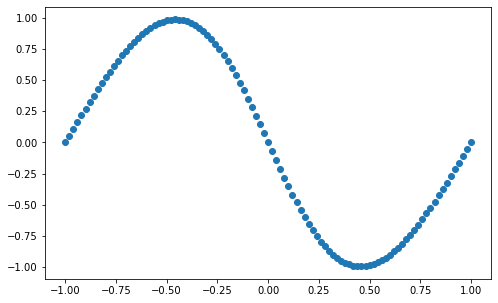

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(x,u,'o', lw=0.1)

### Решение нейронной сети

#### Вариант 1

In [49]:
x_test = np.linspace(-1,1,1000).reshape(1000,1)
t_test = np.linspace(0,10,1000).reshape(1000,1)

In [50]:
tf_dict = {x_tf: x_test, t_tf: t_test}

In [51]:
u_star = sess.run(u_pred, tf_dict)

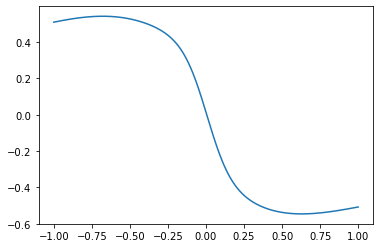

In [52]:
plt.plot(x_test,u_star)
#plt.xlim([-1, 1])

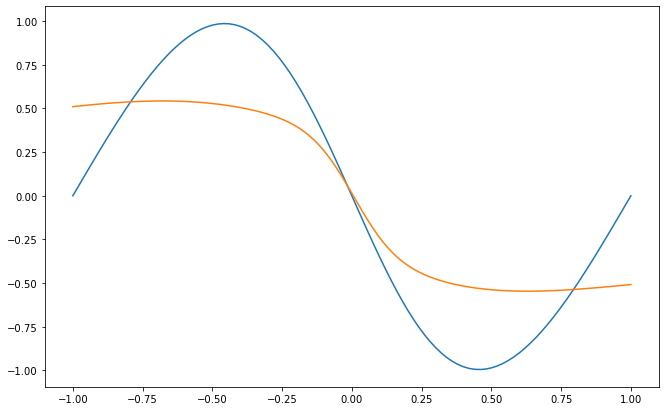

In [53]:
plt.figure(figsize=(11, 7))
plt.plot(x,u, label='Computational')
plt.plot(x_test,u_star, label='neural network')

#### Вариант 2